In [71]:
# imports and laodings
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statistics

# settings
basal_conditions = ['control__wt_glc__1'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# defining constants
RNAP = 1*10**(-8)
kEscape = 1
TF = 0
u = 1/3600
kDeg = 0.00231049
promoterConc = 1*10**(-9)
promoterConcVal = 10**(-9)
cell_volume = 10**(-15) # in liters

# getting grid values
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -3
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = 2.5118864315095796e-07#KdRNAP / 10


if True:
    def mRNA_to_cActivator(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening): # this appears to be properly working!
        cActivator = (KdRNAPCrp*(KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + \
                mRNA))/(KdRNAP*(KdRNAP + RNAP + KeqOpening*RNAP - \
                KdRNAPCrp*mRNA - RNAP*mRNA - KeqOpening*RNAP*mRNA))

        return(cActivator)

    def mRNA_to_cInhibitor(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
        cInhibitor = -(((KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + mRNA))/(KdRNAP*mRNA))

        return(cInhibitor)


    def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening):
        mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                KeqOpening)*RNAP)

        return(mRNA)

    def log_tpm_to_mRNA_conc(val):
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
        return(mRNA)

# calculate mRNA predicted and actual values

In [84]:
# TODOS - make this all relative prediction instead
# I can't convert log tpm to mRNA without the gene counts from these
gene = 'b1101'

# constants

offset = 0 # setting the bottom or top to true zero makes the formulas weird, so I'm bumping everything off of that by X%
if True:
    # crp is the activator
    act_vals = []
    mRNAs = []
    index = []
    actual_counts = []
    log_x_un = min(log_tpm_df.loc[gene])
    log_x_c = log_tpm_df.loc[gene][basal_conditions].mean()
    # predict mRNA values
    for key, val in (A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene]).items():
        index.append(key)
        mRNA = 2**(val+log_x_c-log_x_un)
        mRNAs.append(mRNA)
        actual_counts.append(2**(log_tpm_df.loc[gene][key] - log_x_un))
        
    act_values_df = pd.DataFrame(index = index)
    act_values_df['mRNA'] = mRNAs
    act_values_df['actual_mRNA'] = actual_counts

    # calculate activator values
    for index, row in act_values_df.iterrows():
        mRNA = row['mRNA']
        cActivator = mRNA_to_cActivator(mRNA)
        act_vals.append(cActivator)
    act_values_df['cActivator'] = act_vals
    
    # mlc is the repressor
    iM = 'DhaR/Mlc'
    inh_vals = []
    mRNAs = []
    index = []
    actual_counts = []
    log_x_un = max(log_tpm_df.loc[gene])
    # predict mRNA values
    for key, val in (A_df.loc[iM]*M_df[iM].loc[gene]).items():
        index.append(key)
        mRNA = 2**(val+log_x_c-log_x_un)
        mRNAs.append(mRNA)
        actual_counts.append(2**(log_tpm_df.loc[gene][key] - log_x_un))
    inh_values_df = pd.DataFrame(index = index)
    inh_values_df['mRNA'] = mRNAs
    inh_values_df['actual_mRNA'] = actual_counts
    
    # scale one by the other
    # calculate inhibitor values
    for index, row in inh_values_df.iterrows():
        mRNA = row['mRNA']
        cInhibitor = mRNA_to_cInhibitor(mRNA)
        inh_vals.append(cInhibitor)
    inh_values_df['cInhibitor'] = inh_vals

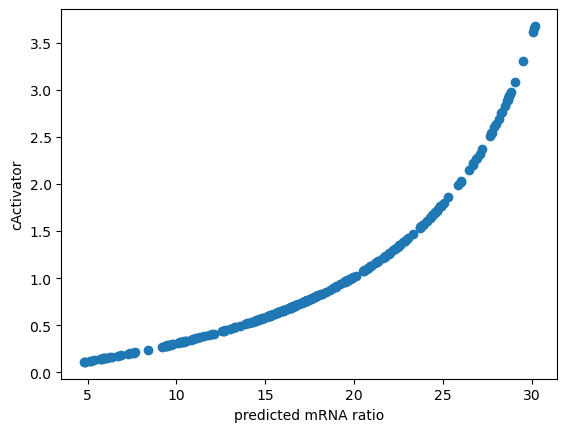

In [85]:
plt.scatter(act_values_df['mRNA'], act_values_df['cActivator'])
plt.xlabel('predicted mRNA ratio')
plt.ylabel('cActivator')
plt.show()

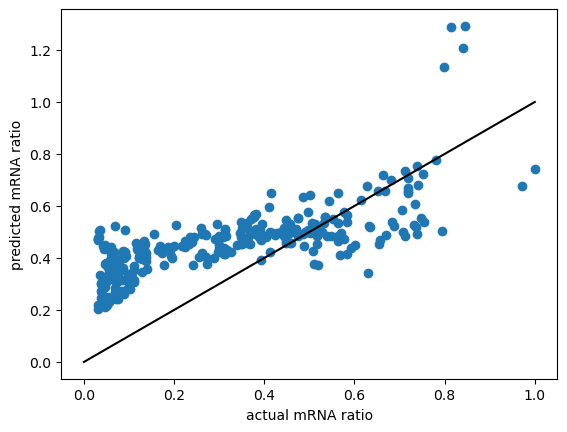

In [86]:
plt.scatter(inh_values_df['actual_mRNA'], inh_values_df['mRNA'])
plt.plot([0, 1], [0, 1], color = 'k')
plt.xlabel('actual mRNA ratio')
plt.ylabel('predicted mRNA ratio')
plt.show()

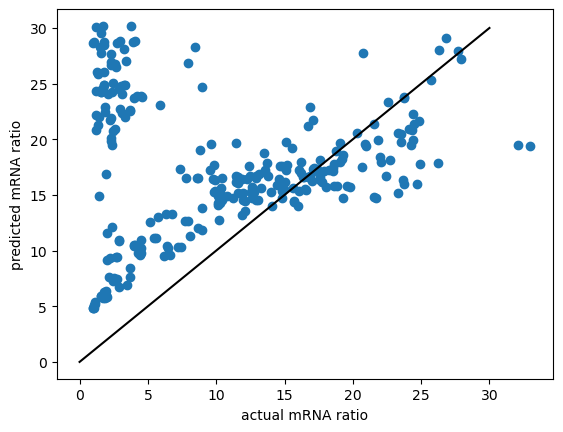

In [87]:
plt.scatter(act_values_df['actual_mRNA'], act_values_df['mRNA'])
plt.plot([0, 30], [0, 30], color = 'k')
plt.xlabel('actual mRNA ratio')
plt.ylabel('predicted mRNA ratio')
plt.show()

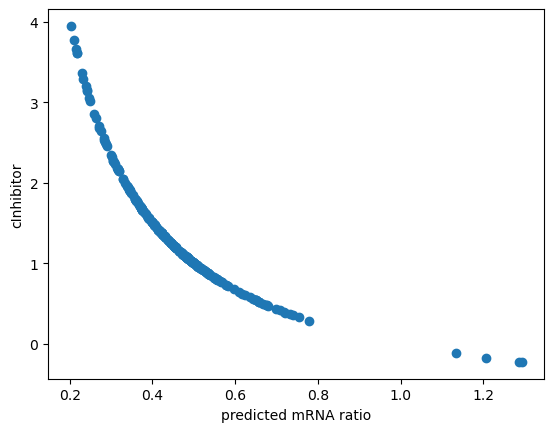

In [88]:
plt.scatter(inh_values_df['mRNA'], inh_values_df['cInhibitor'])
plt.xlabel('predicted mRNA ratio')
plt.ylabel('cInhibitor')
plt.show()

# parameter optimization

Optimization successful.
KdRNAPCrp = 5.255359952695447e-06


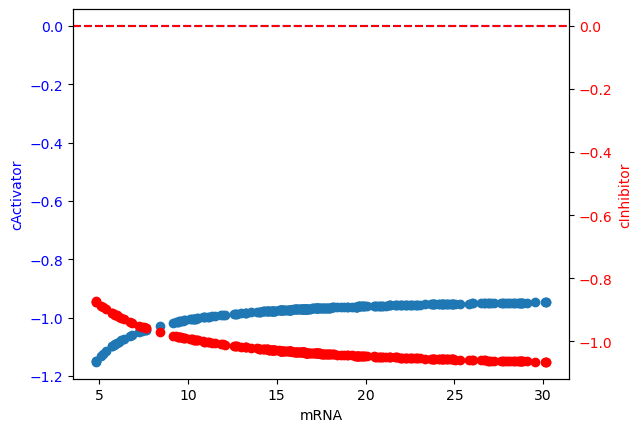

In [97]:
# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])

activator_mRNA_values = list(act_values_df.sort_values(by = 'mRNA').mRNA.values)
inhibitor_mRNA_values = list(inh_values_df.sort_values(by = 'mRNA').mRNA.values)

def objective(x):
    KdRNAPCrp_temp = x[0]
    KdRNAP_temp = KdRNAP
    KeqOpening_temp = KeqOpening
    RNAP_temp = KdRNAP
    
    if KdRNAPCrp_temp > KdRNAP:
        # this doesn't make biological sense
        return(1e10) # return a high penalty
    
    cActivator_values = []
    for mRNA in activator_mRNA_values:
        cActivator = mRNA_to_cActivator(mRNA, RNAP = RNAP_temp, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, KeqOpening = KeqOpening_temp)
        cActivator_values.append(cActivator)
        
    cInhibitor_values = []
    for mRNA in inhibitor_mRNA_values:
        cInhibitor = mRNA_to_cInhibitor(mRNA, RNAP = RNAP_temp, KdRNAP = KdRNAP_temp, KeqOpening = KeqOpening_temp)
        cInhibitor_values.append(cInhibitor)
    
    penalty = 0
    diff = 0
    diff += abs(100 - abs(max(cActivator_values) - min(cActivator_values)))
    diff += abs((100 - abs((max(cInhibitor_values) - min(cInhibitor_values)))))
    
    #diff += abs(max(cActivator_values) - min(cActivator_values))
    #diff += abs(max(cInhibitor_values) - min(cInhibitor_values))
    
    if min(cActivator_values) < 0 or cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif min(cInhibitor_values) < 0 or cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    
    if cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
        
    return diff + penalty
    
# Initial guess for KdRNAP and KdRNAPCrp values
x0 = [KdRNAPCrp]#, KdRNAP, KeqOpening, RNAP]

# Bounds for KdRNAP and KdRNAPCrp values
n = 100000000
bounds = [(KdRNAPCrp/n, KdRNAPCrp*n)]#, (KdRNAP/n, KdRNAP*n), (KeqOpening/n, KeqOpening*n), (RNAP/n, RNAP*n)]

# basinhopping
result = basinhopping(objective,  x0 = x0, minimizer_kwargs={"bounds": bounds}, niter = 100)

if result.success:
    KdRNAPCrp_opt = result.x[0]
    print("Optimization successful.")
    print("KdRNAPCrp =", KdRNAPCrp_opt)
else:
    print("Optimization failed. Unable to find suitable values.")
    KdRNAPCrp_opt = result.x[0]
    print("KdRNAPCrp =", KdRNAPCrp_opt)
    
# plot
KdRNAPCrp_temp = result.x[0]
fig, ax = plt.subplots()
vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
ax.scatter(act_values_df['mRNA'], vals)
plt.xlabel('mRNA')
ax.set_ylabel('cActivator', color = 'blue')
ax.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax.twinx()
vals = mRNA_to_cInhibitor(act_values_df['mRNA'])
ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
ax2.set_ylabel('cInhibitor', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
#plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
ax2.axhline(y = 0, linestyle = '--', color = 'red')
ax.axhline(y = 0, linestyle = '--', color = 'blue')
plt.show()

1e-05


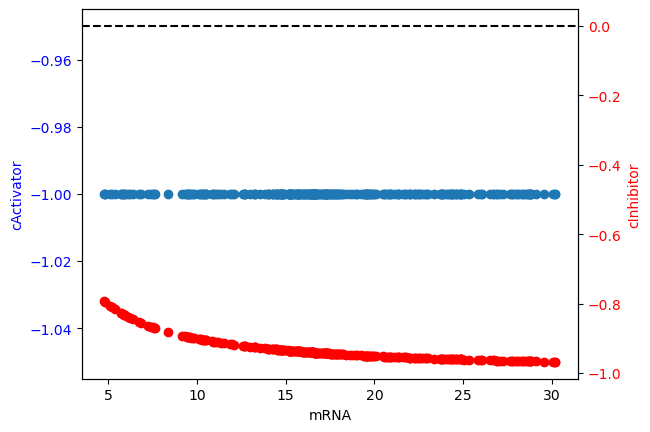

6.309573444801933e-06


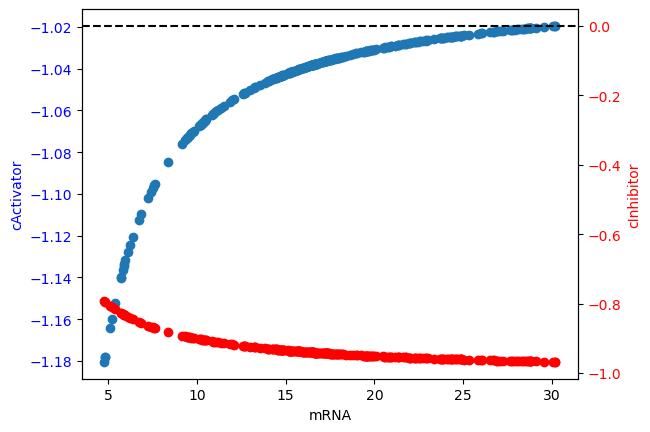

3.9810717055349725e-06


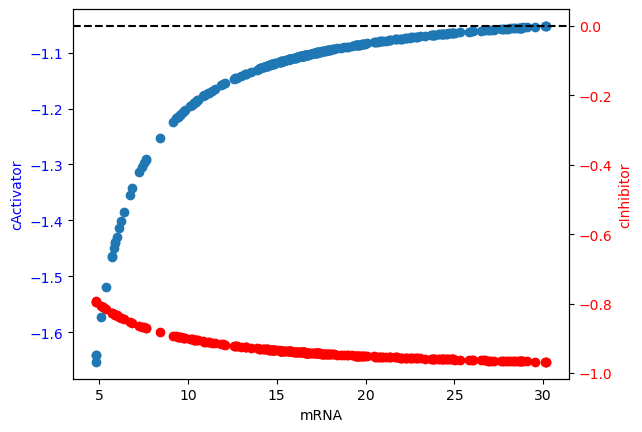

2.51188643150958e-06


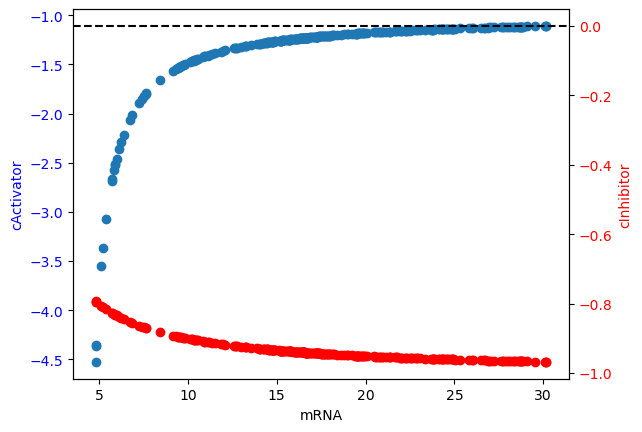

1.5848931924611137e-06


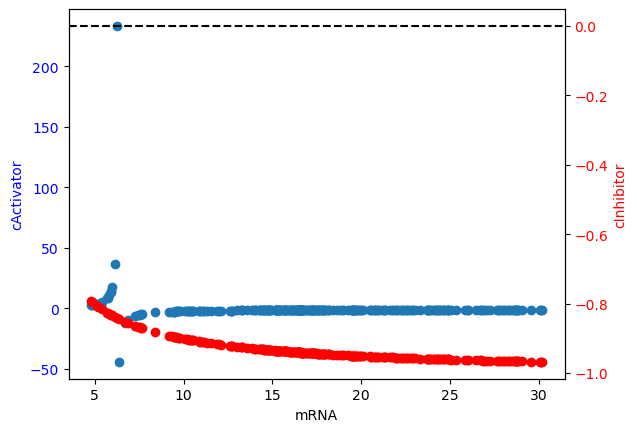

1.0000000000000002e-06


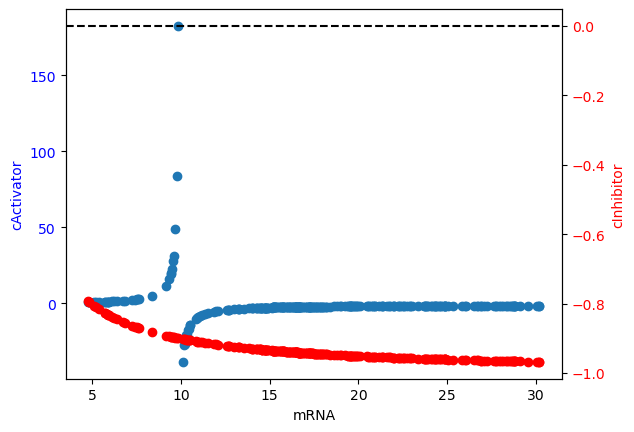

6.309573444801934e-07


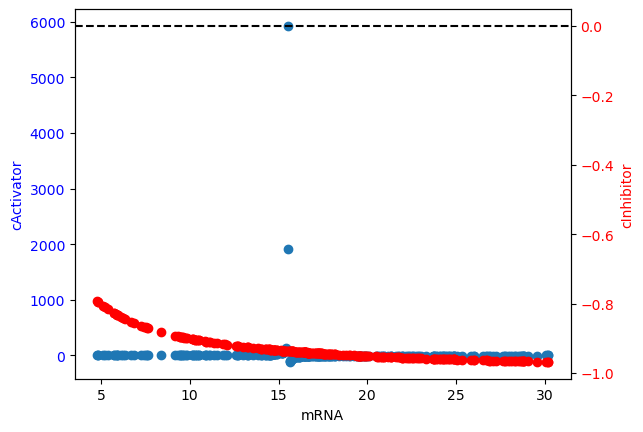

3.981071705534974e-07


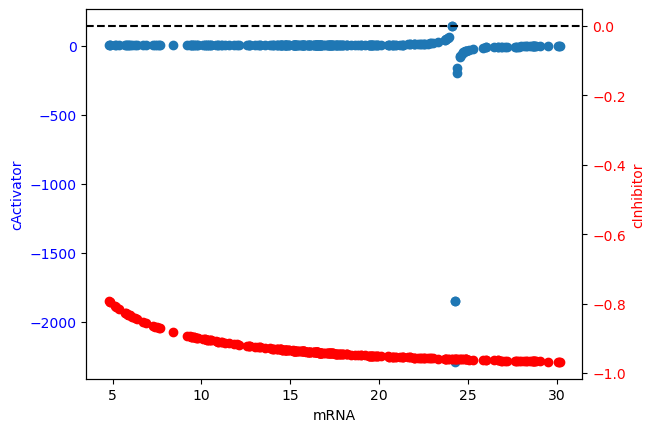

2.5118864315095796e-07


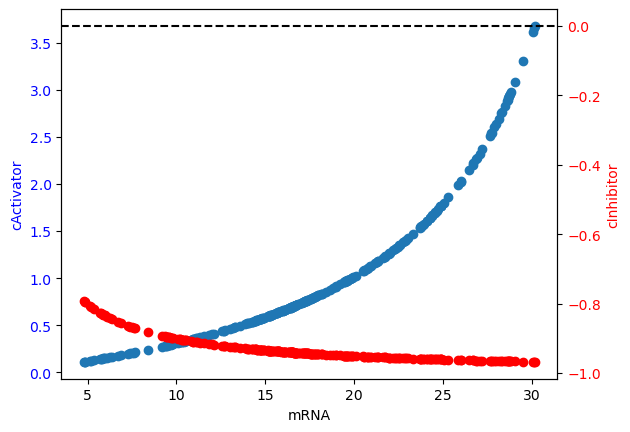

1.5848931924611136e-07


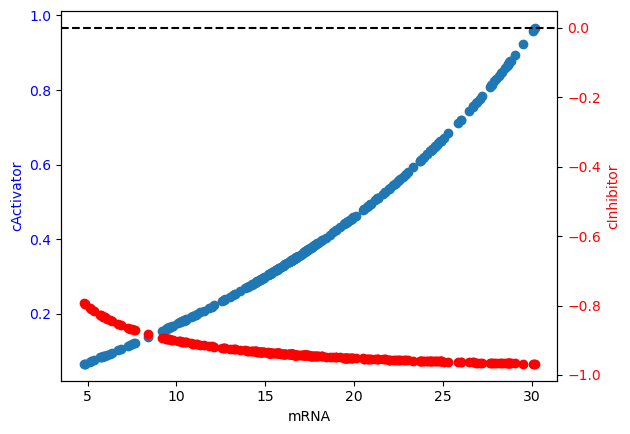

1.0000000000000001e-07


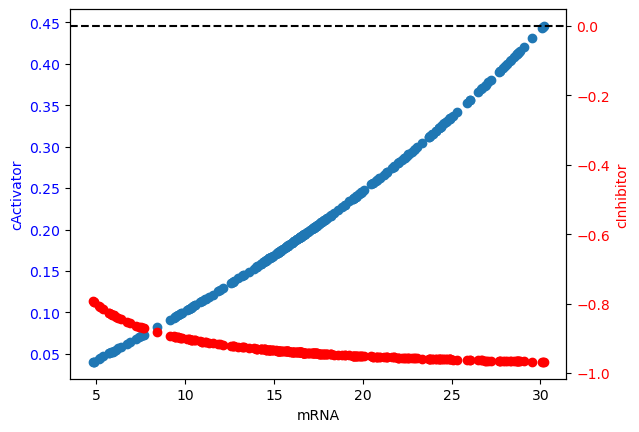

6.309573444801931e-08


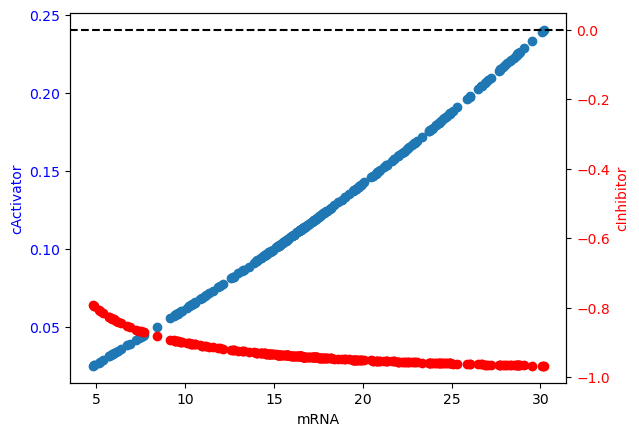

3.9810717055349736e-08


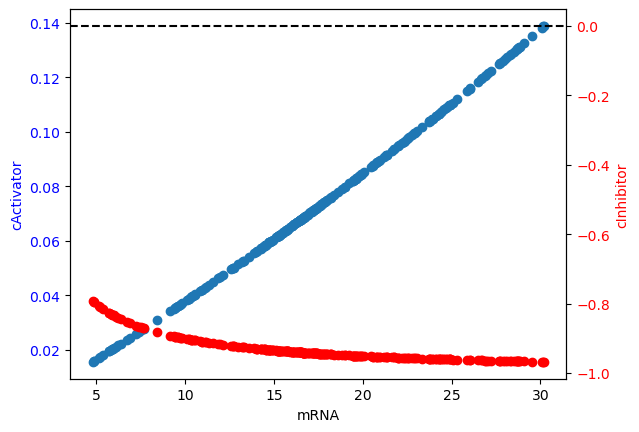

2.5118864315095798e-08


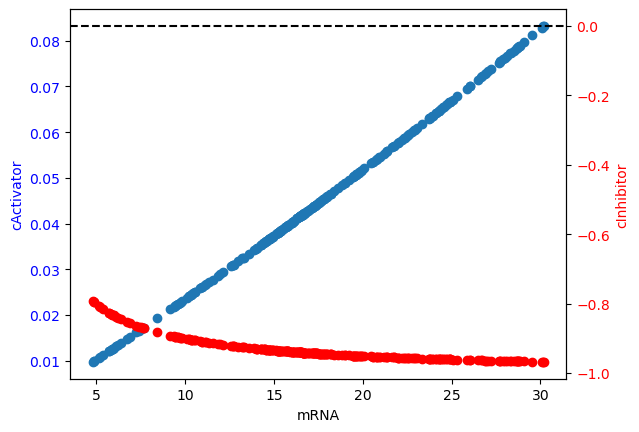

1.5848931924611143e-08


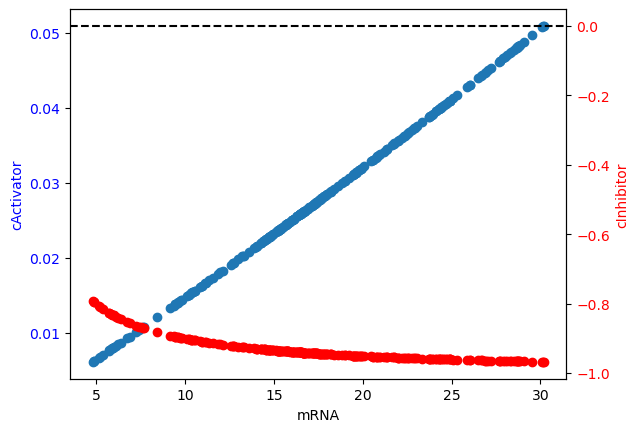

1e-08


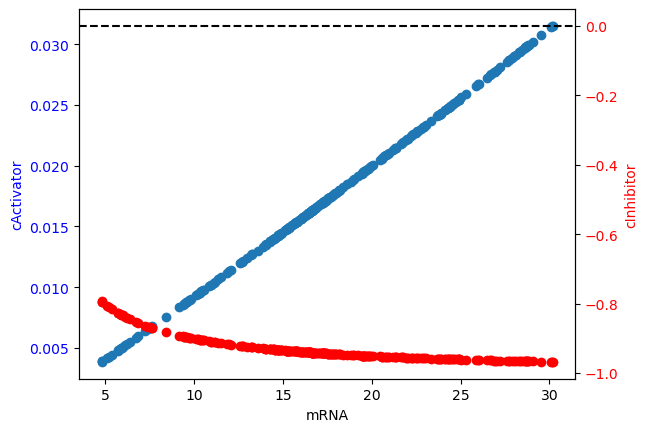

6.3095734448019305e-09


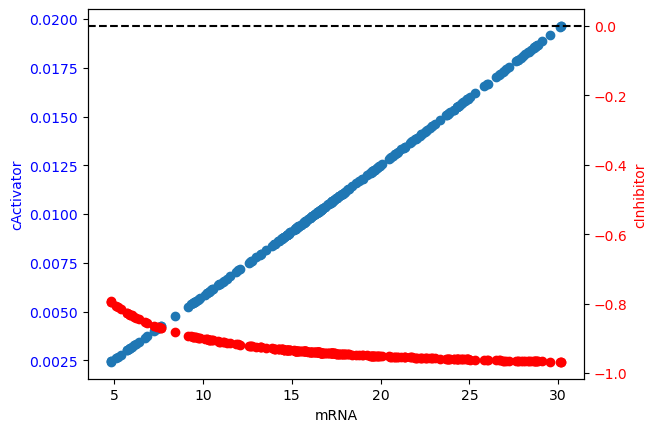

3.981071705534974e-09


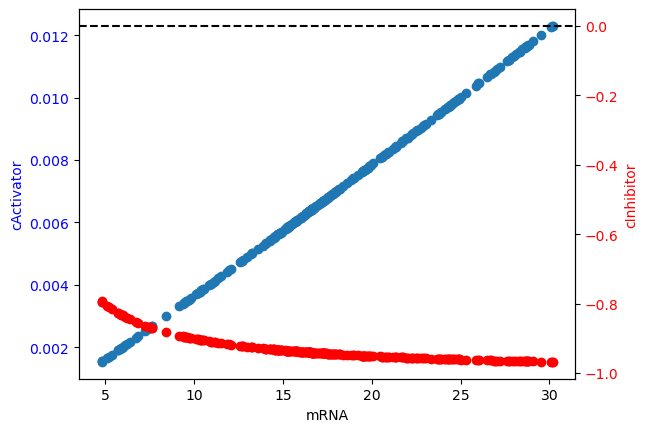

2.51188643150958e-09


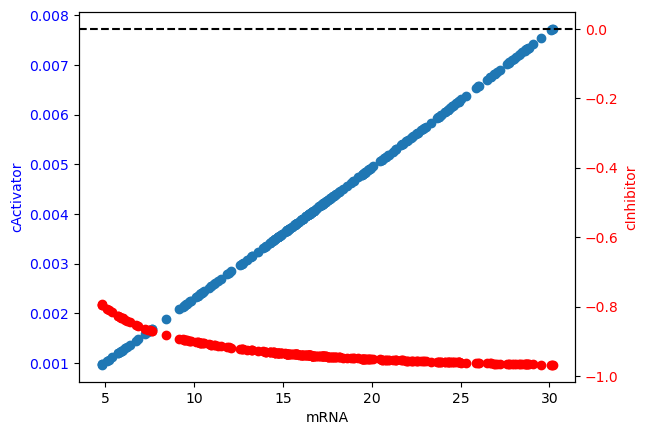

1.5848931924611142e-09


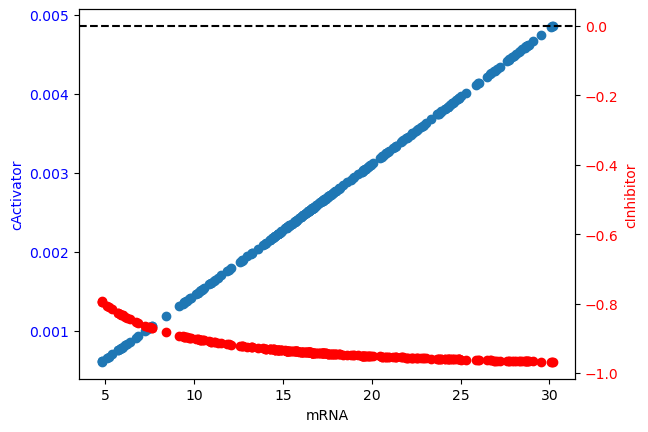

In [52]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it

# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val/5)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(act_values_df['mRNA'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    #ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(act_values_df['mRNA'])
    ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    #ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    #plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    #plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()

In [ ]:
np.linspace(0, 10, 10)

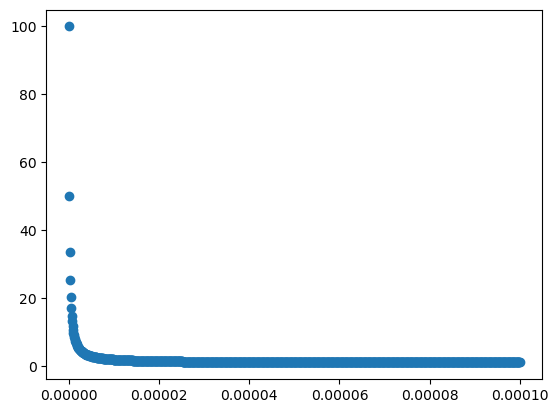

In [25]:
# I want to move the vTransc line

# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = KdRNAP / 100
x_vals = []
y_vals = []
for x_val in np.linspace(RNAP/100000000, RNAP*100, 1000):
    vTransc = (KdRNAP + x_val + KeqOpening*x_val)/(KdRNAPCrp + x_val + KeqOpening*x_val)
    y_vals.append(vTransc)
    x_vals.append(x_val)
plt.scatter(x_vals, y_vals)
plt.show()

# predicting

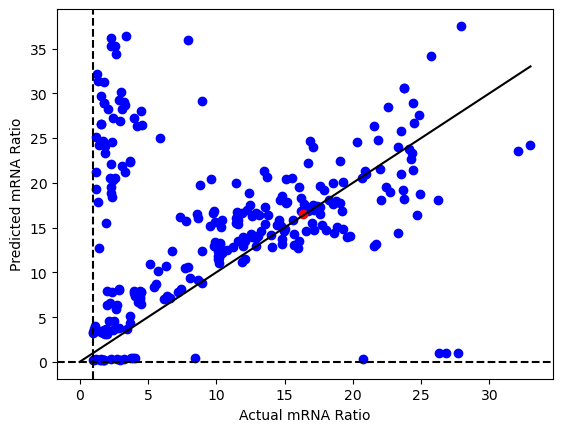

In [121]:
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
KdRNAPCrp = 2.5118864315095796e-07*1.4
predicted_mRNA = []
actual_mRNA = list(act_values_df.actual_mRNA)
for index in act_values_df.index:
    cActivator 
cActivator_cInhibitor_to_mRNA
cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = KdRNAPCrp) for val in act_values_df['mRNA'].values]).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
unhighlighted = []
highlighted = []
for index in act_values_df.index:
    if index in basal_conditions:
        highlighted.append(index)
    else:
        unhighlighted.append(index)
        
# use these cActivator and cInhibitor values to calculate ptsG tpm and compare to known
cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[unhighlighted], KdRNAPCrp = KdRNAPCrp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[unhighlighted])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[unhighlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'blue')

cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[highlighted], KdRNAPCrp = KdRNAPCrp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[highlighted])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[highlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'red')

plt.xlabel('Actual mRNA Ratio')
plt.ylabel('Predicted mRNA Ratio')
plt.axvline(x = 1, color = 'k', linestyle = '--')
plt.axhline(y = 0, color = 'k', linestyle = '--')
#plt.axis('equal')
plt.plot([0, max(act_values_df.actual_mRNA)], [0, max(act_values_df.actual_mRNA)], color = 'k')
plt.show()

In [230]:
# save our predictions
def calculate_z_scores(data):
    mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    z_scores = [(x - mean) / stdev for x in data]
    return z_scores

preds_df = pd.DataFrame(index = act_values_df.index)
cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = KdRNAPCrp) for val in act_values_df['mRNA'].values]).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
preds_df['cActivator_z'] = np.array(calculate_z_scores(cActivator_vals)).clip(min = 0.1)
preds_df['cInhibitor_z'] = np.array(calculate_z_scores(cInhibitor_vals)).clip(min = 0.1)
preds_df['cActivator_vals_unit'] = preds_df['cActivator_z'] / (preds_df['cActivator_z']  + preds_df['cInhibitor_z'])
preds_df['cInhibitor_vals_unit'] = preds_df['cInhibitor_z'] / (preds_df['cActivator_z']  + preds_df['cInhibitor_z'])
preds_df['predicted_mRNA_fold_change'] = predicted_mRNA
preds_df['predicted_log_tpm'] = np.log2(predicted_mRNA) + min(log_tpm_df.loc[gene])
preds_df['actual_log_tpm'] = log_tpm_df.loc[gene][preds_df.index]

preds_df.to_pickle('../data/saved_ptsG_predictions.pkl')

In [231]:
preds_df

,cActivator_z,cInhibitor_z,cActivator_vals_unit,cInhibitor_vals_unit,predicted_mRNA_fold_change,predicted_log_tpm,actual_log_tpm
control__wt_glc__1,0.1,0.100000,0.500000,0.500000,16.514657,11.139795,11.128750
control__wt_glc__2,0.1,0.100000,0.500000,0.500000,15.335629,11.032936,11.244418
fur__wt_dpd__1,0.1,0.531895,0.158254,0.841746,5.149899,9.458664,8.972448
fur__wt_dpd__2,0.1,0.733492,0.119977,0.880023,4.350913,9.215438,8.977670
fur__wt_fe__1,0.1,0.100000,0.500000,0.500000,16.373144,11.127380,10.813057
...,...,...,...,...,...,...,...
efeU__menFentCubiC_ale36__2,0.1,0.100000,0.500000,0.500000,13.018499,10.796611,11.066907
efeU__menFentCubiC_ale37__1,0.1,0.100000,0.500000,0.500000,14.051261,10.906748,10.798183
efeU__menFentCubiC_ale37__2,0.1,0.100000,0.500000,0.500000,13.933129,10.894568,10.748277
efeU__menFentCubiC_ale38__1,0.1,0.100000,0.500000,0.500000,15.370176,11.036182,10.858594


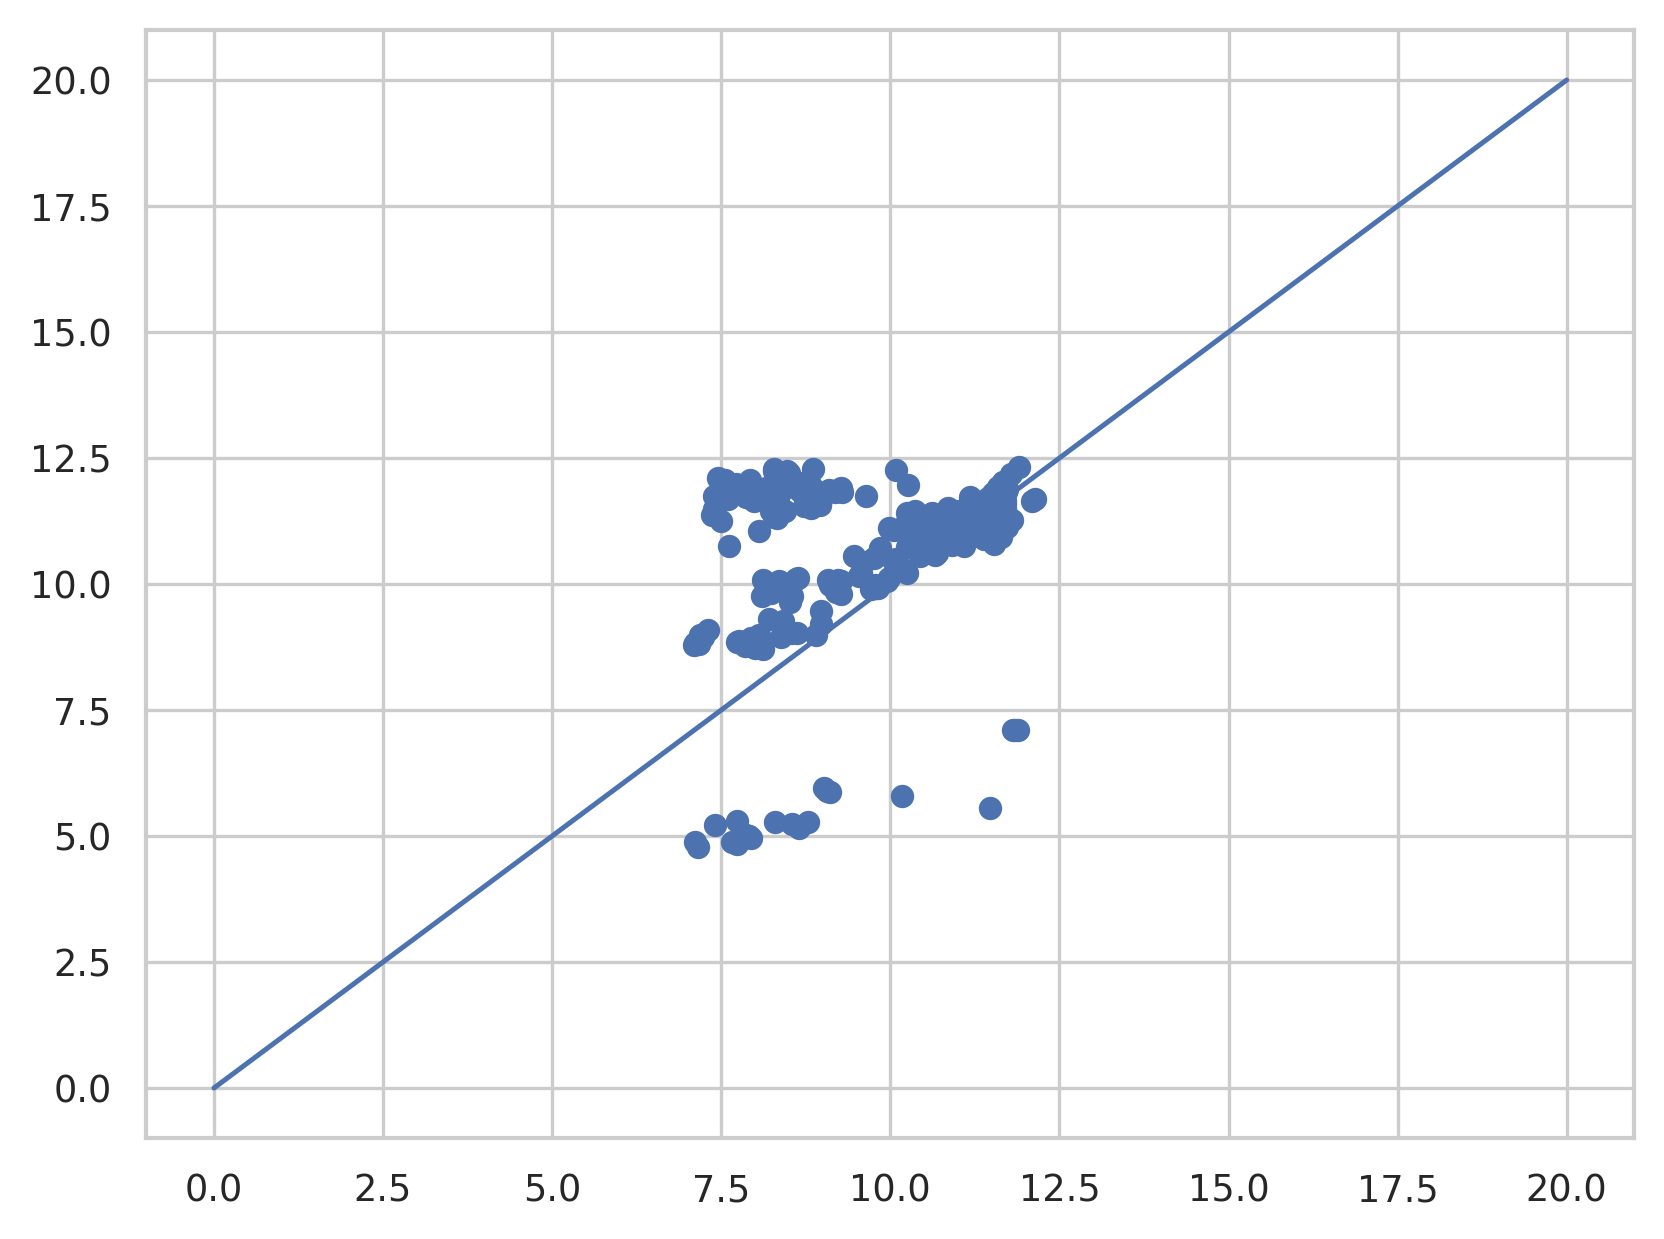

In [232]:
plt.scatter(preds_df['actual_log_tpm'], preds_df['predicted_log_tpm'])
plt.plot([0, 20], [0, 20])
plt.show()

In [171]:
b / (a+b)

0.5769230769230769

In [161]:
cActivator_vals / max(cActivator_vals)

array([6.73585830e-03, 6.21485092e-03, 1.80027638e-03, 1.54396315e-03,
       6.97072661e-03, 7.45187524e-03, 2.60950836e-03, 2.79160667e-03,
       4.88479710e-03, 4.84089652e-03, 4.87358393e-03, 4.68726311e-03,
       5.43188059e-03, 5.16441877e-03, 5.50562796e-03, 5.39202221e-03,
       5.11976648e-03, 5.08240513e-03, 2.19324103e-03, 2.22032428e-03,
       2.51925513e-03, 2.52122052e-03, 2.47143818e-03, 2.43209410e-03,
       2.26841823e-03, 2.23220596e-03, 2.47493746e-03, 2.55703958e-03,
       3.29389766e-03, 3.23272924e-03, 2.29714043e-03, 2.31890495e-03,
       1.43390394e-03, 1.48211825e-03, 3.66475825e-03, 3.67882883e-03,
       2.61602902e-03, 2.57029499e-03, 7.35932003e-03, 7.25322824e-03,
       3.69983293e-03, 4.50785043e-03, 7.26881637e-03, 7.55658156e-03,
       8.35509300e-03, 8.06621044e-03, 5.55581652e-03, 5.64299990e-03,
       2.97766349e-03, 5.87468186e-03, 5.52603126e-03, 5.89329492e-03,
       5.84542368e-03, 5.39509298e-03, 6.09193440e-03, 1.35990695e-01,
      

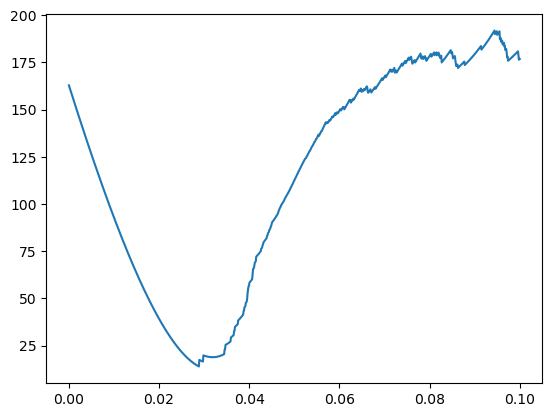

In [111]:
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
Kd_vals = []
err_vals = []
min_err = 9e99
best_val = None
for KdRNAPCrp in np.linspace(KdRNAP/100000, KdRNAP/10, 1000):
    predicted_mRNA = []
    actual_mRNA = list(act_values_df.actual_mRNA)
    for index in act_values_df.index:
        cActivator 
    cActivator_cInhibitor_to_mRNA
    cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = KdRNAPCrp) for val in act_values_df['actual_mRNA'].values]).clip(min = 0)
    cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['actual_mRNA'])).clip(min = 0)
    predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)

    Kd_vals.append(KdRNAPCrp / KdRNAP)
    err = mean_squared_error(actual_mRNA, predicted_mRNA)
    if err < min_err:
        min_err = err
        best_val = KdRNAPCrp / KdRNAP
    err_vals.append(err)
plt.plot(Kd_vals, err_vals)

# 3D plot - I don't have access to bitome2 currently so just doing here instead of archan's stuff

In [139]:
A_df

,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,efeU__menFentC_ale29__1,efeU__menFentC_ale29__2,efeU__menFentC_ale30__1,efeU__menFentC_ale30__2,efeU__menFentCubiC_ale36__1,efeU__menFentCubiC_ale36__2,efeU__menFentCubiC_ale37__1,efeU__menFentCubiC_ale37__2,efeU__menFentCubiC_ale38__1,efeU__menFentCubiC_ale38__2
YieP,0.076035,-0.076035,1.483992,1.719034,-1.184220,-1.350203,1.451882,1.329577,0.265718,0.024864,...,-0.892372,-1.022146,0.253722,-0.880352,0.526509,1.261740,1.727782,1.512944,2.584012,2.787686
GlpR,-0.408568,0.408568,1.760680,1.357274,-0.446482,-0.931725,0.517458,0.427993,-0.499529,-0.581335,...,1.781224,2.785099,0.439133,-0.015471,0.366544,0.369589,0.325470,1.027508,1.629269,2.154717
YgbI,0.103912,-0.103912,0.847276,1.530875,0.258492,0.188903,1.232846,0.883215,0.505356,0.132219,...,1.422466,2.396554,2.130935,1.656316,0.864338,0.093698,0.641705,1.306455,1.366912,2.452061
efeU-repair,-0.456843,0.456843,5.890468,6.051415,-0.914670,-1.087245,5.210846,5.028641,3.820172,3.961980,...,-2.343743,-1.991048,3.520794,3.105551,6.620301,5.400225,5.545880,5.555621,9.672308,10.109228
ydcI-KO,0.269057,-0.269057,-0.254271,0.184537,0.651527,0.691914,0.016636,-0.465781,1.212097,1.122801,...,-3.646464,-3.606055,-0.665810,-0.830586,-1.044574,0.119876,-0.045670,-0.826608,-1.393160,-1.587978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FecI,0.688270,-0.688270,5.634716,6.108603,0.219454,0.003060,5.158511,4.370987,3.103733,3.583433,...,7.764427,8.760619,7.821128,7.703410,-2.884336,-2.367138,-4.110394,-3.634405,-0.519113,-1.947274
iron-related,-0.626840,0.626840,-14.701300,-15.597267,0.845967,1.162655,-13.510683,-12.957594,-13.096025,-13.314456,...,0.119792,-0.960111,-0.680352,1.018403,-6.899176,-5.952147,-9.010493,-8.105965,1.585767,1.073398
RbsR,0.430457,-0.430457,-3.372701,-4.162934,0.068287,-0.165654,-2.873520,-2.519696,0.260477,0.368015,...,2.113651,2.100231,2.356222,2.885853,-0.075934,0.302996,-2.005424,-1.295221,-2.102694,-2.068330
sgrT,-0.048835,0.048835,-5.160815,-6.092148,-0.353515,-0.450102,-5.567270,-4.689035,-0.468733,-0.600372,...,-4.718127,-4.736551,-3.864097,-2.652361,-4.589338,-2.989324,-2.270104,-3.646678,-5.310318,-4.133685


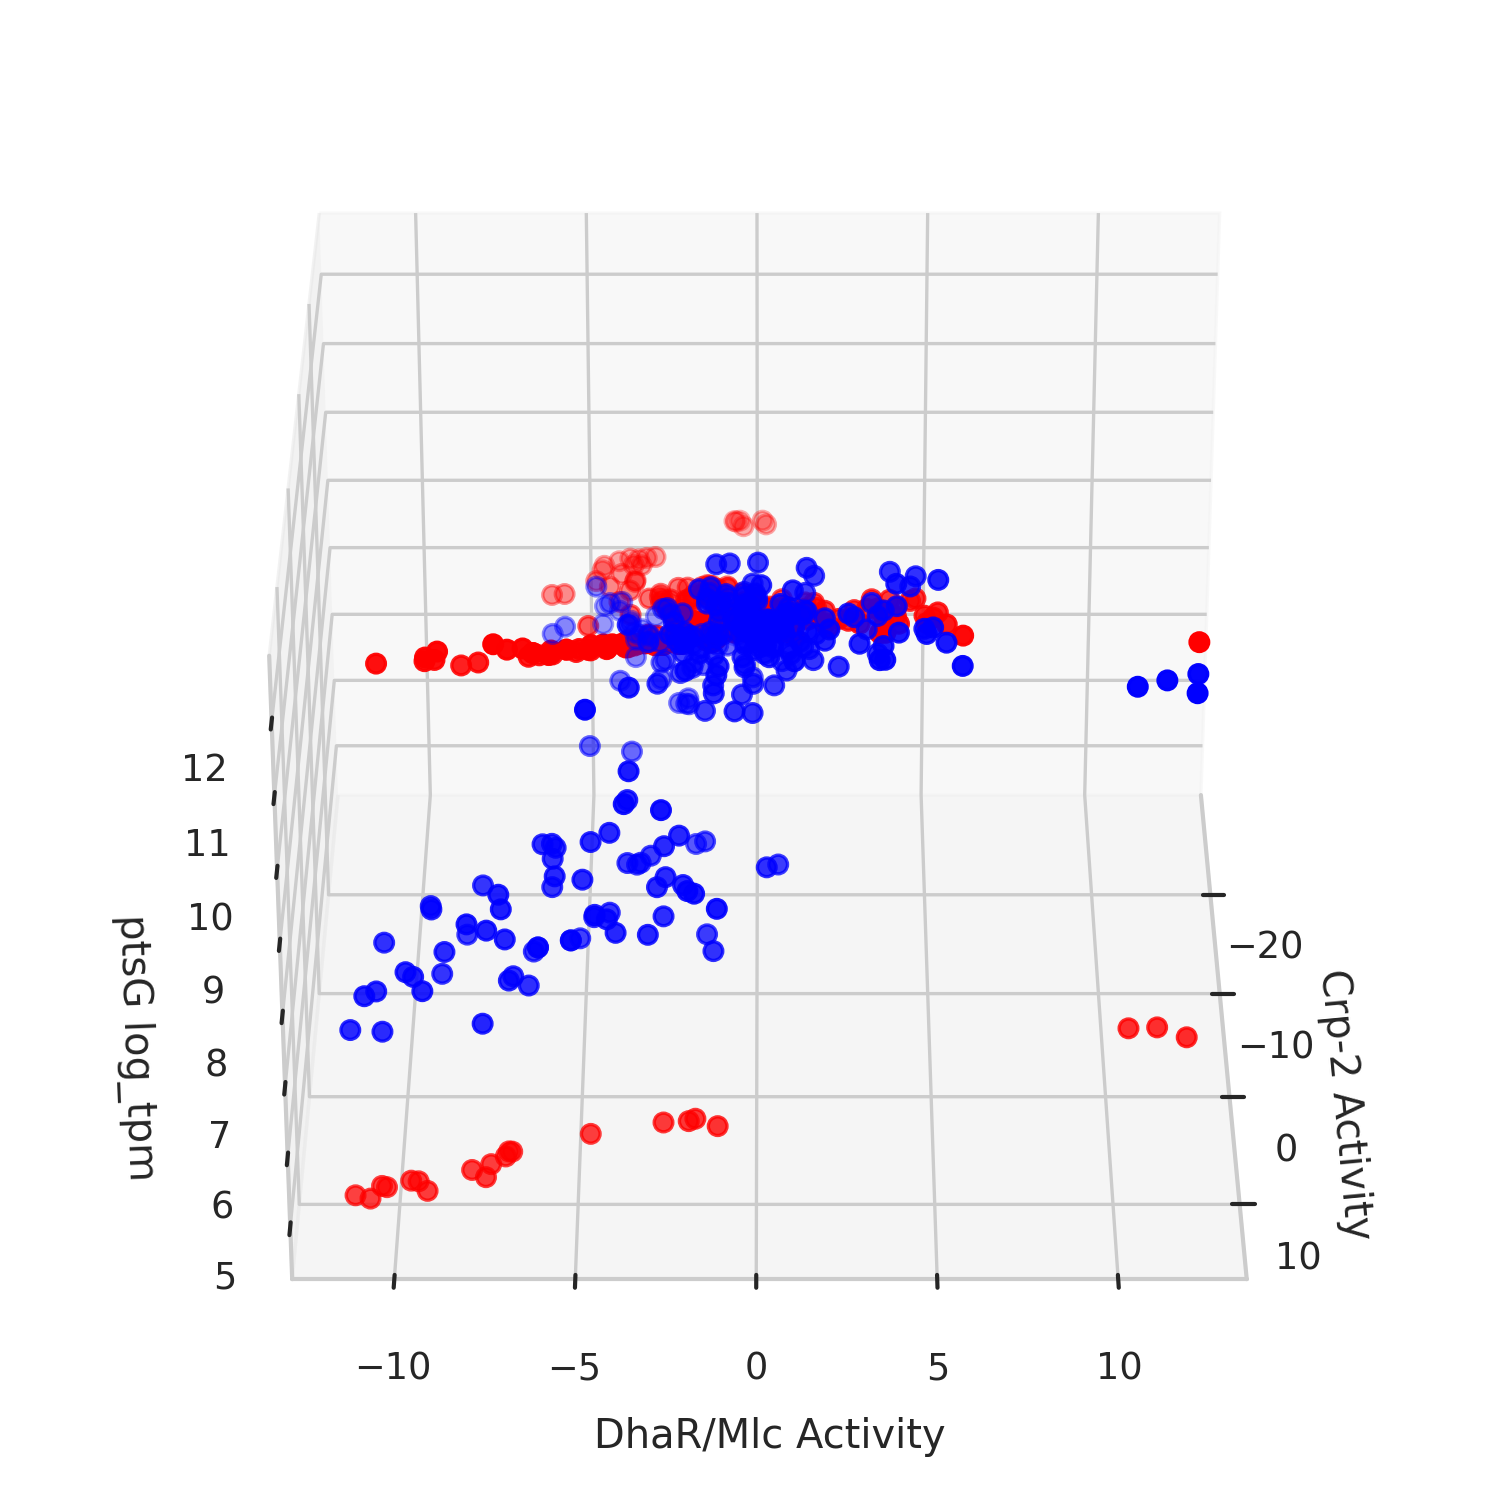

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

plt.rcParams["figure.dpi"] = 300
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(A_df.loc['Crp-2'], A_df.loc['DhaR/Mlc'], preds_df['actual_log_tpm'], color = 'blue')
ax.scatter(A_df.loc['Crp-2'], A_df.loc['DhaR/Mlc'], preds_df['predicted_log_tpm'], color = 'red')
ax.set_xlabel('Crp-2 Activity')
ax.set_ylabel('DhaR/Mlc Activity')
ax.set_zlabel('ptsG log_tpm')

# this function defines the animation action done to the plot
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('./densmap_complete.gif', writer=animation.PillowWriter(fps=10))

# playground

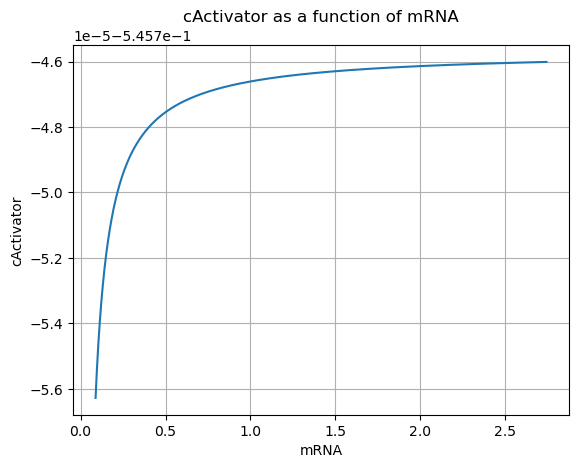

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = KdRNAP / 10

if False:
    # Define parameter values # set from cActivator fixing
    KdRNAPCrp = 1e-07 # 10**(-7) # just magnitude # SET GOOD
    KdRNAP = 10 #1*10**(-3) # shifts left to right # SET GOOD
    RNAP = 1e-06 # 1*10**(-6) # affects spread # SET GOOD
    KeqOpening = 10**(grid_vals[grid_use][2])
    kDeg = 0.00231049
    promoterConcVal = 10**(-9)
    u = 1/3600

# Generate mRNA values
mRNA_values = np.linspace(min(act_values_df['mRNA']), max(act_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

# Evaluate cActivator for each mRNA value
cActivator_values = [cActivator_expression(KdRNAPCrp, KdRNAP, RNAP, KeqOpening, kDeg, promoterConcVal, g, u) for g in mRNA_values]

# Calculate variance of cActivator values
variance = np.var(cActivator_values)

# Find mRNA values with the highest variance
max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
mRNA_values_with_max_variance = mRNA_values[max_variance_indices]

# Plot the results
plt.plot(mRNA_values, cActivator_values)
plt.xlabel('mRNA')
plt.ylabel('cActivator')
plt.title('cActivator as a function of mRNA')
plt.grid(True)
plt.show()


0.01


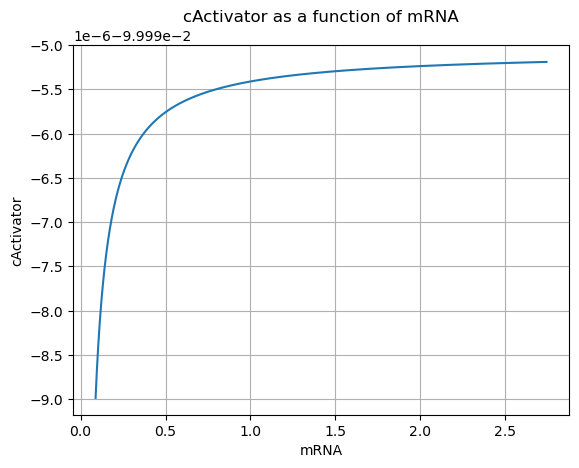

0.01


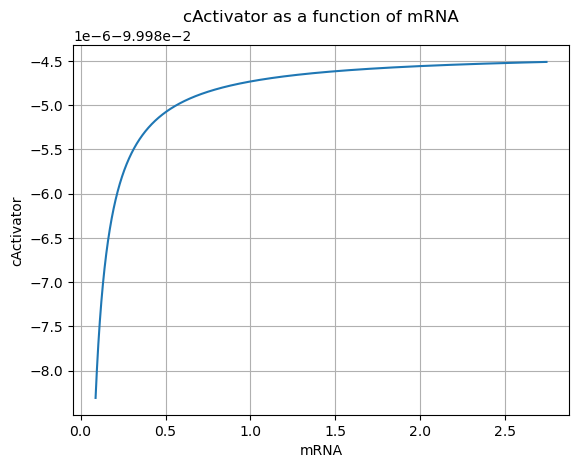

0.01


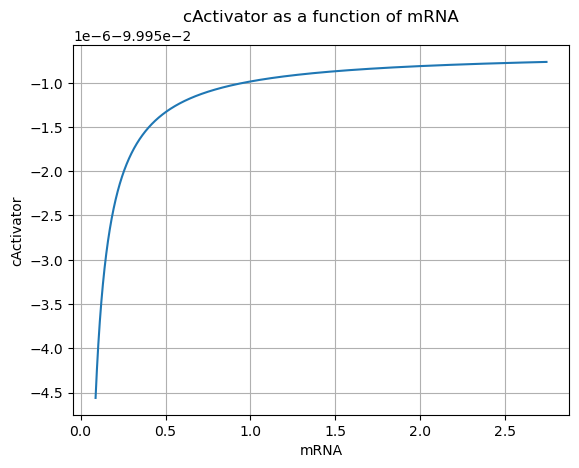

0.01


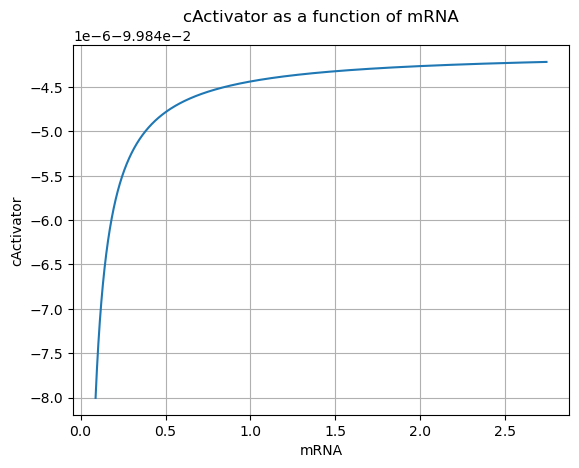

0.01


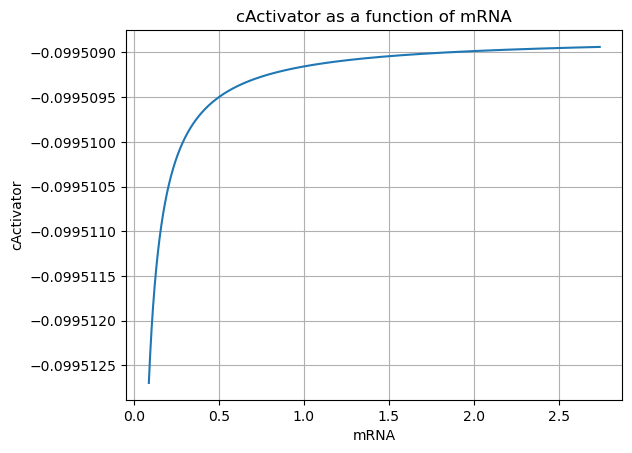

0.01


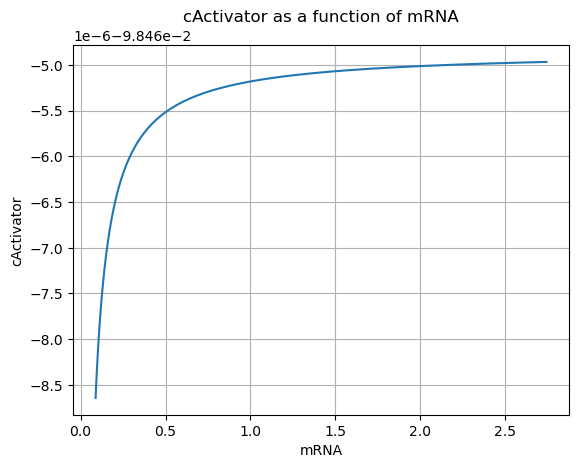

0.01


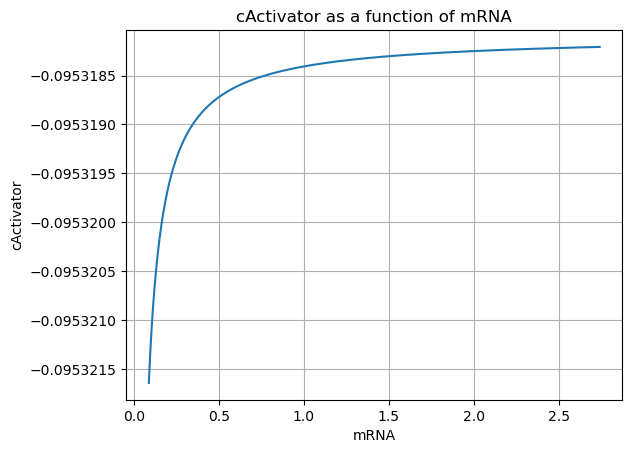

0.01


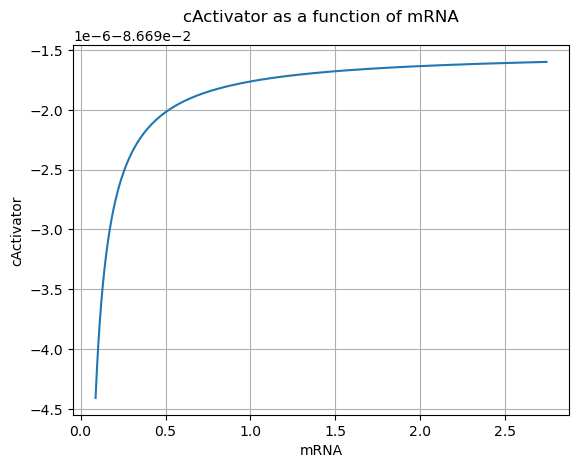

0.01


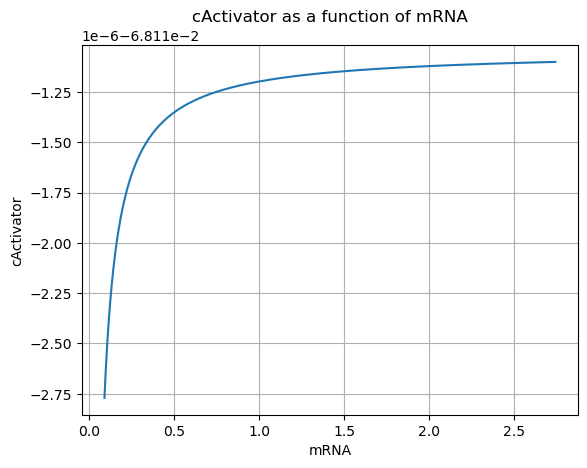

0.01


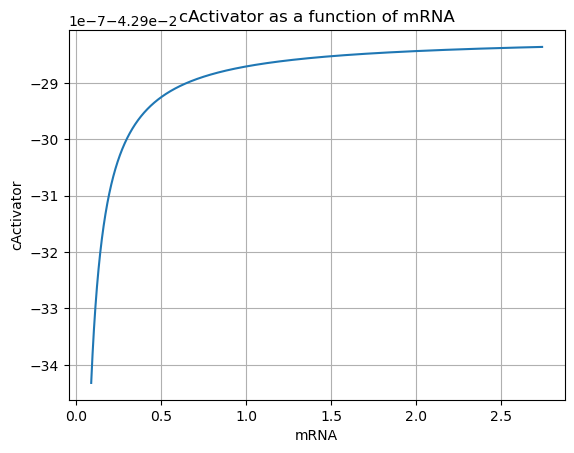

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator


# Define parameter values
KdRNAPCrp = 1e-07 # 10**(-7) # just magnitude # SET GOOD
KdRNAP = 10**(grid_vals[grid_use][0]) #1*10**(-3) # shifts left to right # SET GOOD
RNAP = 1e-06 # 1*10**(-6) # affects spread # SET GOOD
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

if True:
    for val in range(10):
        KeqOpening_temp = KeqOpening*10**((val-5)/2)
    
        print(RNAP_temp)
        # Generate mRNA values
        mRNA_values = np.linspace(min(act_values_df['mRNA']), max(act_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

        # Evaluate cActivator for each mRNA value
        cActivator_values = [cActivator_expression(KdRNAPCrp, KdRNAP, RNAP, KeqOpening_temp, kDeg, promoterConcVal, g, u) for g in mRNA_values]

        # Calculate variance of cActivator values
        variance = np.var(cActivator_values)

        # Find mRNA values with the highest variance
        max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
        mRNA_values_with_max_variance = mRNA_values[max_variance_indices]

        # Plot the results
        plt.plot(mRNA_values, cActivator_values)
        plt.xlabel('mRNA')
        plt.ylabel('cActivator')
        plt.title('cActivator as a function of mRNA')
        plt.grid(True)
        plt.show()


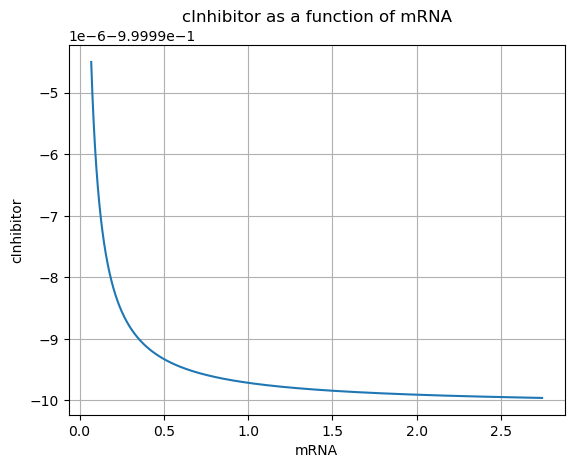

In [181]:
# SIMILAR THING AS ABOVE BUT FOR CINHIBITOR


import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Define parameter values # set from cActivator fixing
KdRNAPCrp = 1e-07 
KdRNAP = 10 
RNAP = 1e-06 
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Generate mRNA values
mRNA_values = np.linspace(min(inh_values_df['mRNA']), max(inh_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

# Evaluate cActivator for each mRNA value
cActivator_values = [mRNA_to_cInhibitor(g, KdRNAP = KdRNAP, RNAP = RNAP, KeqOpening = KeqOpening) for g in mRNA_values]

# Calculate variance of cActivator values
variance = np.var(cActivator_values)

# Find mRNA values with the highest variance
max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
mRNA_values_with_max_variance = mRNA_values[max_variance_indices]


# Plot the results
plt.plot(mRNA_values, cActivator_values)
plt.xlabel('mRNA')
plt.ylabel('cInhibitor')
plt.title('cInhibitor as a function of mRNA')
plt.grid(True)
plt.show()


1.908860976328061e-07


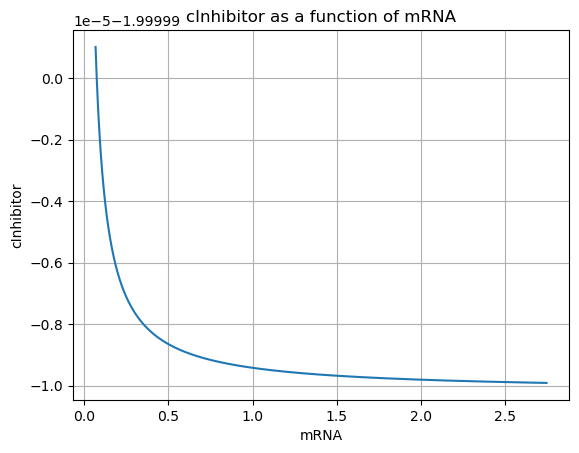

1.908860976328061e-06


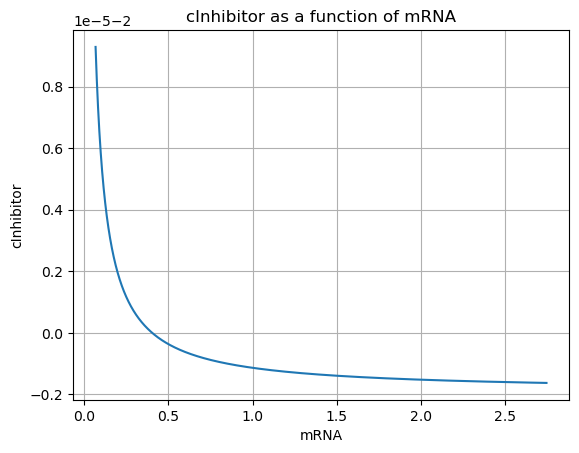

1.908860976328061e-05


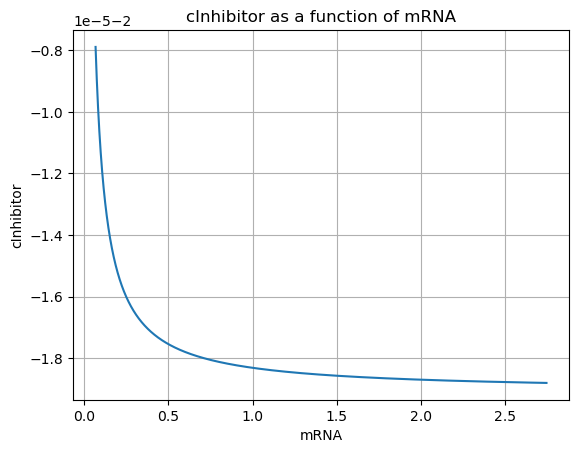

0.00019088609763280608


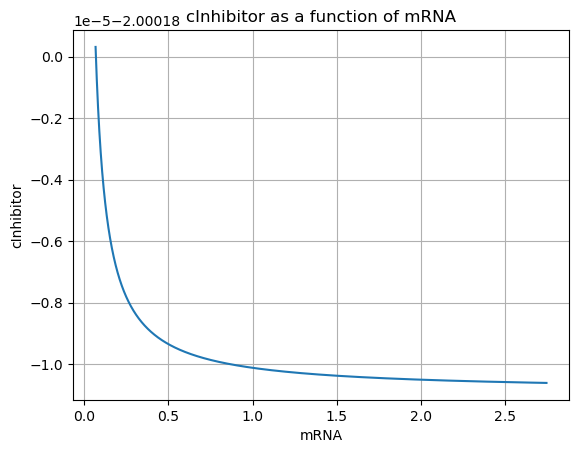

0.001908860976328061


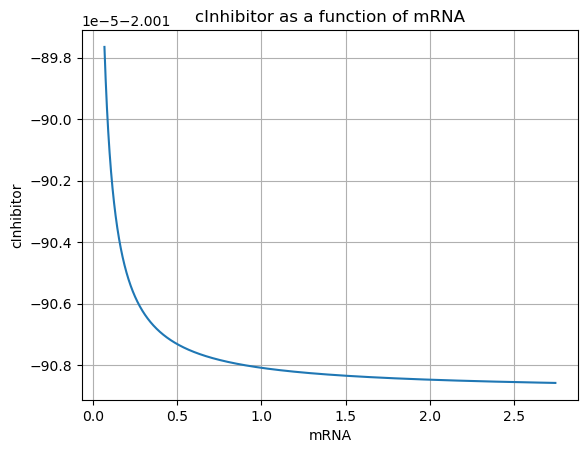

0.01908860976328061


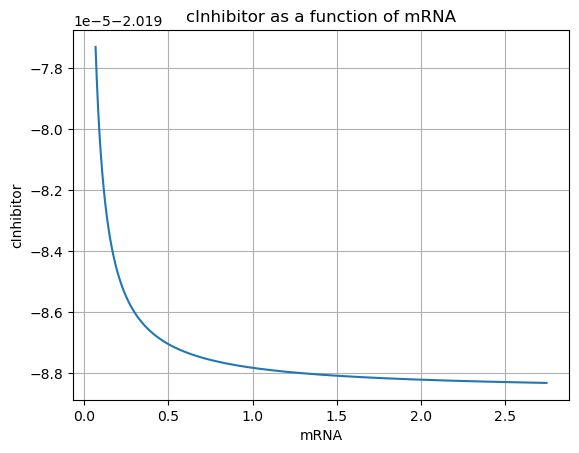

0.1908860976328061


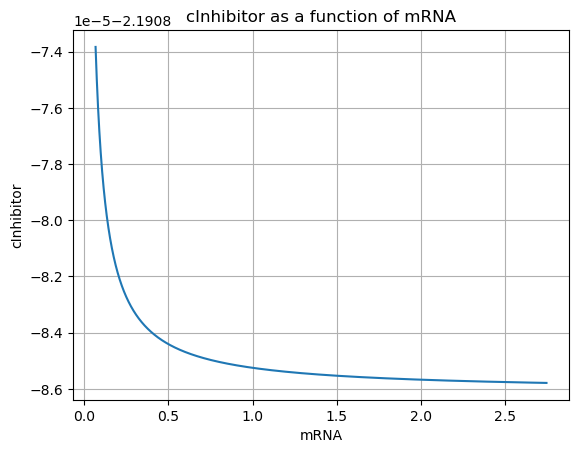

1.9088609763280608


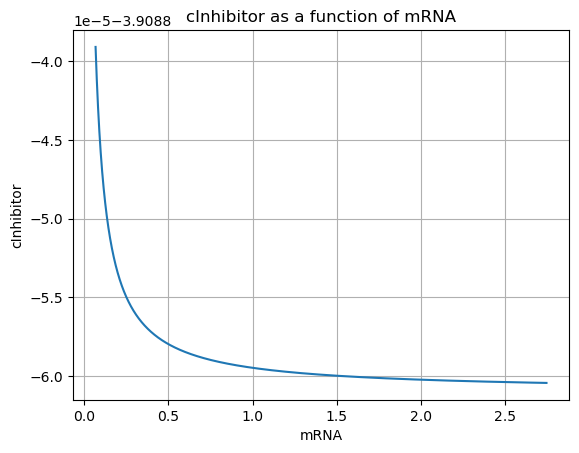

19.08860976328061


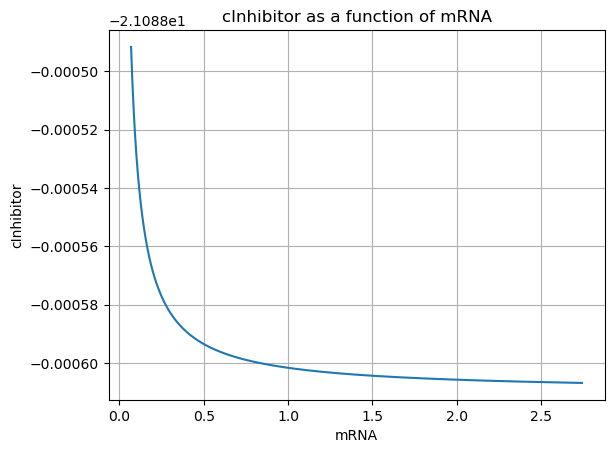

190.88609763280607


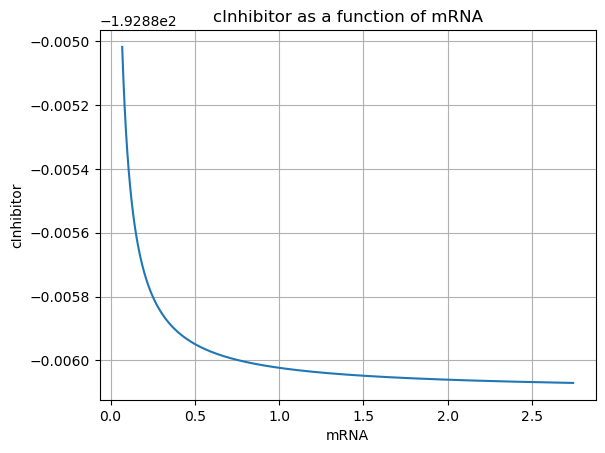

In [186]:
# SIMILAR THING AS ABOVE BUT FOR CINHIBITOR


import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Define parameter values # set from cActivator fixing
KdRNAP = 10 
RNAP = 1e-06 
KeqOpening = 10**(grid_vals[grid_use][2]) # scale changes, maybe pos/neg?
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

if True:
    for val in range(10):
        kDeg_temp = kDeg*10**((val-5))
    
        print(kDeg_temp)
        # Generate mRNA values
        mRNA_values = np.linspace(min(inh_values_df['mRNA']), max(inh_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

        # Evaluate cActivator for each mRNA value
        cActivator_values = [mRNA_to_cInhibitor(g, KdRNAP = KdRNAP, RNAP = KdRNAP, KeqOpening = KeqOpening_temp) for g in mRNA_values]

        # Calculate variance of cActivator values
        variance = np.var(cActivator_values)

        # Find mRNA values with the highest variance
        max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
        mRNA_values_with_max_variance = mRNA_values[max_variance_indices]


        # Plot the results
        plt.plot(mRNA_values, cActivator_values)
        plt.xlabel('mRNA')
        plt.ylabel('cInhibitor')
        plt.title('cInhibitor as a function of mRNA')
        plt.grid(True)
        plt.show()


In [ ]:
(((KdRNAP + RNAP + KeqOpening*RNAP)*(kDeg*mRNA - promoterConcVal + \
                    mRNA*u))/(KdRNAP*mRNA*(kDeg + u)))